In [3]:
import pandas as pd
import utils.DataEngine as de
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import re
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from scipy.stats import norm
import scipy.stats as st
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from ipywidgets import interact
from scipy import interpolate
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures

In [4]:
data = de.DataEngine('data2024')
round_5_df = data.data['round_5']['trade_df']

In [30]:
round_5_df.buyer.unique()

array(['Vinnie', 'Remy', 'Ruby', 'Rhianna', 'Valentina', 'Vladimir',
       'Adam', 'Amelia', 'Raj'], dtype=object)

In [32]:
round_5_df.seller.unique()

array(['Ruby', 'Valentina', 'Remy', 'Vinnie', 'Vladimir', 'Rhianna',
       'Amelia', 'Adam', 'Raj'], dtype=object)

In [45]:
round_5_df[round_5_df.buyer == 'Valentina'].symbol.unique()

array(['STARFRUIT', 'AMETHYSTS', 'COCONUT_COUPON'], dtype=object)

Raj only trades coconuts

Rhianna buy signal roses

In [46]:
round_3_data = data.data['round_3']['price_df']
round_4_data = data.data['round_4']['price_df']

straw_rd_3 = round_3_data[round_3_data['product'] == 'STRAWBERRIES']
roses_rd_3 = round_3_data[round_3_data['product'] == 'ROSES']
choco_rd_3 = round_3_data[round_3_data['product'] == 'CHOCOLATE']
coco_rd_4 = round_4_data[round_4_data['product'] == 'COCONUT']
coup_rd_4 = round_4_data[round_4_data['product'] == 'COCONUT_COUPON']

In [47]:
roses_trades = round_5_df[(round_5_df.symbol == 'ROSES')]
straw_trades = round_5_df[(round_5_df.symbol == 'STRAWBERRIES')]
choco_trades = round_5_df[(round_5_df.symbol == 'CHOCOLATE')]
coco_trades = round_5_df[(round_5_df.symbol == 'COCONUT')]
coup_trades = round_5_df[(round_5_df.symbol == 'COCONUT_COUPON')]

In [54]:
roses_merged_df = pd.merge(roses_trades, roses_rd_3, on=['timestamp', 'day'], how='outer')
straw_merged_df = pd.merge(straw_trades, straw_rd_3, on=['timestamp', 'day'], how='outer')
choco_merged_df = pd.merge(choco_trades, choco_rd_3, on=['timestamp', 'day'], how='outer')
coco_merged_df = pd.merge(coco_trades, coco_rd_4, on=['timestamp', 'day'], how='outer')
coup_merged_df = pd.merge(coup_trades, coup_rd_4, on=['timestamp', 'day'], how='outer')

In [55]:
coco_merged_df['buyer'].unique()

array([nan, 'Vinnie', 'Raj', 'Rhianna'], dtype=object)

In [56]:
coco_merged_df[coco_merged_df['buyer'] == 'Raj']

,timestamp,buyer,seller,symbol,currency,price,quantity,day,product,bid_price_1,...,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
93,3009300,Raj,Vinnie,COCONUT,SEASHELLS,10005.0,6.0,1,COCONUT,10003.0,...,NaN,NaN,10005,133,10006.0,64.0,NaN,NaN,10004.0,0.0
432,3043100,Raj,Vinnie,COCONUT,SEASHELLS,9974.0,8.0,1,COCONUT,9972.0,...,NaN,NaN,9974,180,NaN,NaN,NaN,NaN,9973.0,0.0
482,3048100,Raj,Vinnie,COCONUT,SEASHELLS,9969.0,8.0,1,COCONUT,9967.0,...,NaN,NaN,9969,166,NaN,NaN,NaN,NaN,9968.0,0.0
704,3070300,Raj,Vinnie,COCONUT,SEASHELLS,9952.0,7.0,1,COCONUT,9951.0,...,NaN,NaN,9952,119,9953.0,54.0,NaN,NaN,9951.5,0.0
972,3097100,Raj,Vinnie,COCONUT,SEASHELLS,9952.0,7.0,1,COCONUT,9951.0,...,NaN,NaN,9952,131,9953.0,59.0,NaN,NaN,9951.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29638,5959700,Raj,Vinnie,COCONUT,SEASHELLS,9890.0,9.0,3,COCONUT,9889.0,...,NaN,NaN,9890,9,9891.0,148.0,9892.0,41.0,9889.5,0.0
29753,5971200,Raj,Vinnie,COCONUT,SEASHELLS,9885.0,7.0,3,COCONUT,9884.0,...,NaN,NaN,9885,144,9886.0,55.0,NaN,NaN,9884.5,0.0
29875,5983400,Raj,Vinnie,COCONUT,SEASHELLS,9884.0,6.0,3,COCONUT,9883.0,...,NaN,NaN,9884,117,9885.0,73.0,NaN,NaN,9883.5,0.0
29940,5989700,Raj,Vinnie,COCONUT,SEASHELLS,9879.0,5.0,3,COCONUT,9878.0,...,NaN,NaN,9879,133,9880.0,66.0,NaN,NaN,9878.5,0.0


In [58]:
coco_merged_df[coco_merged_df['seller'] == 'Raj']

,timestamp,buyer,seller,symbol,currency,price,quantity,day,product,bid_price_1,...,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
125,3012500,Vinnie,Raj,COCONUT,SEASHELLS,10003.0,10.0,1,COCONUT,10003.0,...,NaN,NaN,10005,104,10006.0,69.0,NaN,NaN,10004.0,0.0
202,3020100,Vinnie,Raj,COCONUT,SEASHELLS,9990.0,10.0,1,COCONUT,9990.0,...,NaN,NaN,9991,111,9992.0,46.0,NaN,NaN,9990.5,0.0
209,3020800,Vinnie,Raj,COCONUT,SEASHELLS,9993.0,10.0,1,COCONUT,9993.0,...,NaN,NaN,9994,137,9995.0,63.0,NaN,NaN,9993.5,0.0
465,3046400,Vinnie,Raj,COCONUT,SEASHELLS,9969.0,8.0,1,COCONUT,9969.0,...,NaN,NaN,9970,142,9971.0,60.0,NaN,NaN,9969.5,0.0
542,3054100,Vinnie,Raj,COCONUT,SEASHELLS,9975.0,6.0,1,COCONUT,9975.0,...,NaN,NaN,9977,103,9978.0,41.0,NaN,NaN,9976.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29528,5948700,Vinnie,Raj,COCONUT,SEASHELLS,9887.0,6.0,3,COCONUT,9887.0,...,NaN,NaN,9889,195,NaN,NaN,NaN,NaN,9888.0,0.0
29675,5963400,Vinnie,Raj,COCONUT,SEASHELLS,9897.0,9.0,3,COCONUT,9897.0,...,NaN,NaN,9899,193,NaN,NaN,NaN,NaN,9898.0,0.0
29904,5986200,Vinnie,Raj,COCONUT,SEASHELLS,9878.0,9.0,3,COCONUT,9878.0,...,NaN,NaN,9879,120,9880.0,43.0,NaN,NaN,9878.5,0.0
29963,5992000,Vinnie,Raj,COCONUT,SEASHELLS,9887.0,9.0,3,COCONUT,9887.0,...,NaN,NaN,9888,100,9889.0,68.0,NaN,NaN,9887.5,0.0


In [63]:
coco_merged_df.iloc[93:].head(20)

,timestamp,buyer,seller,symbol,currency,price,quantity,day,product,bid_price_1,...,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
93,3009300,Raj,Vinnie,COCONUT,SEASHELLS,10005.0,6.0,1,COCONUT,10003.0,...,NaN,NaN,10005,133,10006.0,64.0,NaN,NaN,10004.0,0.0
94,3009400,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT,10003.0,...,NaN,NaN,10004,101,10005.0,72.0,NaN,NaN,10003.5,0.0
95,3009500,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT,10005.0,...,NaN,NaN,10006,148,10007.0,42.0,NaN,NaN,10005.5,0.0
96,3009600,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT,10006.0,...,NaN,NaN,10007,127,10008.0,61.0,NaN,NaN,10006.5,0.0
97,3009700,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT,10005.0,...,NaN,NaN,10007,163,NaN,NaN,NaN,NaN,10006.0,0.0
98,3009800,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT,10005.0,...,NaN,NaN,10007,214,NaN,NaN,NaN,NaN,10006.0,0.0
99,3009900,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT,10005.0,...,NaN,NaN,10006,102,10007.0,58.0,NaN,NaN,10005.5,0.0
100,3010000,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT,10004.0,...,NaN,NaN,10005,106,10006.0,53.0,NaN,NaN,10004.5,0.0
101,3010100,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT,10005.0,...,NaN,NaN,10006,118,10007.0,72.0,NaN,NaN,10005.5,0.0
102,3010200,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT,10006.0,...,NaN,NaN,10007,124,10008.0,77.0,NaN,NaN,10006.5,0.0


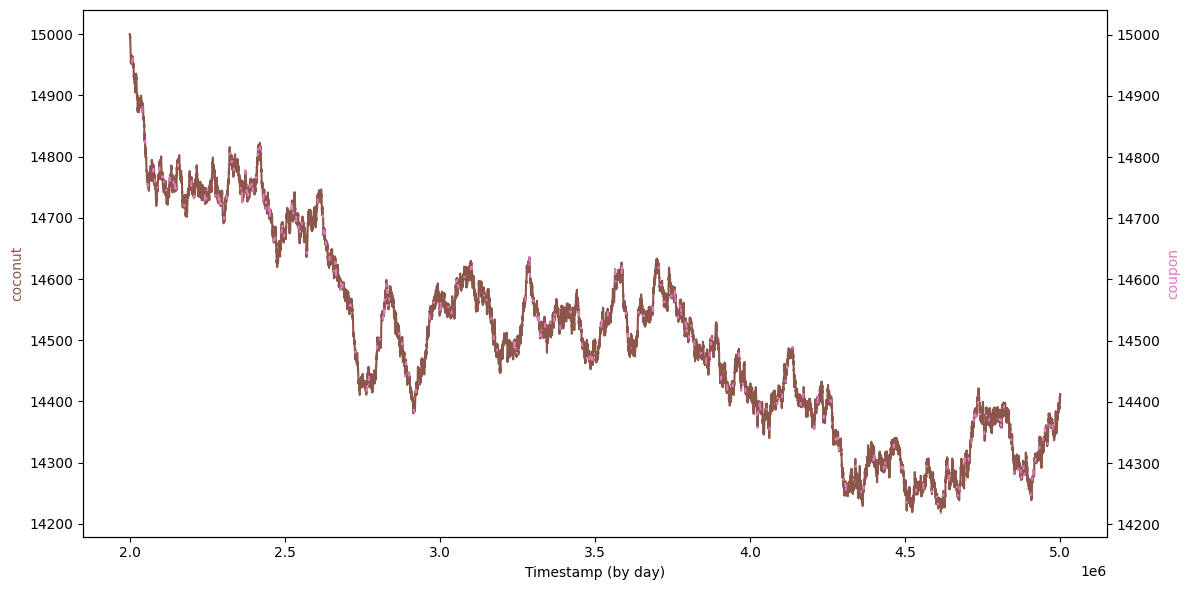

In [93]:
fig, ax1 = plt.subplots(figsize=(12, 6))

shift = 0

color = 'tab:brown'
ax1.set_xlabel('Timestamp (by day)')
ax1.set_ylabel('coconut', color=color)
ax1.plot(roses_merged_df.timestamp.iloc[shift:], roses_merged_df.mid_price.iloc[shift:], color=color, zorder=1)

ax2 = ax1.twinx()
color = 'tab:pink'
ax2.set_xlabel('Timestamp (by day)')
ax2.set_ylabel('coupon', color=color)
ax2.plot(roses_merged_df.timestamp.iloc[shift:], roses_merged_df.price, color=color, zorder=1)

fig.tight_layout()
plt.show()

In [39]:
round_5_df['symbol'].unique()

array(['AMETHYSTS', 'STARFRUIT', 'ROSES', 'CHOCOLATE', 'STRAWBERRIES',
       'GIFT_BASKET', 'COCONUT_COUPON', 'COCONUT'], dtype=object)

In [6]:
rd4_data = pd.read_csv("logs/round4_results.csv")

In [15]:
coconut = rd4_data[rd4_data['product'] == 'COCONUT']
coconut_coupon = rd4_data[rd4_data['product'] == 'COCONUT_COUPON']
gift_basket = rd4_data[rd4_data['product'] == 'GIFT_BASKET']
orchids = rd4_data[rd4_data['product'] == 'ORCHIDS']
strawberries = rd4_data[rd4_data['product'] == 'STRAWBERRIES']
chocolate = rd4_data[rd4_data['product'] == 'CHOCOLATE']
roses = rd4_data[rd4_data['product'] == 'ROSES']

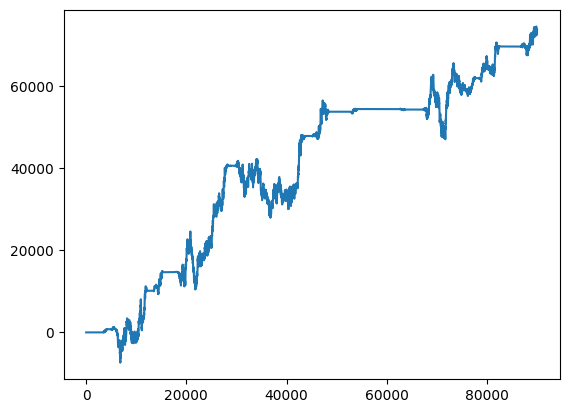

In [28]:
plt.plot(gift_basket.profit_and_loss)